In [1]:
using Pkg
Pkg.add(;path="/Users/az/Documents/GitHub/GLOM_RV_Example")

   Updating git-repo `/Users/az/Documents/GitHub/GLOM_RV_Example`


   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
Updating `~/Documents/GitHub/GLOM_RV_Example/examples/Project.toml`
  [3d369fb6] ~ GLOM_RV_Example v0.1.0 `/Users/az/Documents/GitHub/GLOM_RV_Example#main` ⇒ v0.1.0 `/Users/az/Documents/GitHub/GLOM_RV_Example#main`
Updating `~/Documents/GitHub/GLOM_RV_Example/examples/Manifest.toml`
  [3d369fb6] ~ GLOM_RV_Example v0.1.0 `/Users/az/Documents/GitHub/GLOM_RV_Example#main` ⇒ v0.1.0 `/Users/az/Documents/GitHub/GLOM_RV_Example#main`


In [2]:

Pkg.activate("examples")
Pkg.instantiate()

 Activating environment at `~/Documents/GitHub/GLOM_RV_Example/examples/examples/Project.toml`


In [3]:
import Pkg; Pkg.add("CSV")

using Statistics

# for det()
using LinearAlgebra

# for importing the data from CSV
using DataFrames
using CSV


  Resolving package versions...
No Changes to `~/Documents/GitHub/GLOM_RV_Example/examples/examples/Project.toml`
No Changes to `~/Documents/GitHub/GLOM_RV_Example/examples/examples/Manifest.toml`


In [4]:
# For GLOM
# import Pkg; Pkg.add("GPLinearODEMaker")
import GPLinearODEMaker; GLOM = GPLinearODEMaker

GPLinearODEMaker

In [5]:
# For this module
using GLOM_RV_Example; GLOM_RV = GLOM_RV_Example

GLOM_RV_Example

In [6]:
# For units in orbit fitting functions
import Pkg; Pkg.add("Unitful")
using UnitfulAstro, Unitful

  Resolving package versions...
No Changes to `~/Documents/GitHub/GLOM_RV_Example/examples/examples/Project.toml`
No Changes to `~/Documents/GitHub/GLOM_RV_Example/examples/examples/Manifest.toml`


In [7]:

## Problem setup

# CHANGE: choose a kernel, I suggest 3 for Matern 5/2 or 4 for Quasi-periodic
# kernel
kernel_choice = 4
kernel_names = ["pp", "se", "m52", "qp", "m52_m52", "se_se"]
kernel_name = kernel_names[kernel_choice]
kernel_function, num_kernel_hyperparameters = GLOM.include_kernel(kernel_name)

(GPLinearODEMaker.qp_kernel, 3)

In [8]:
# CHANGE: the stars rotation rate which is used as the first guess for some GLOM
# hyperparameters and starting point for priors
star_rot_rate = 16.28  # days

# importing Yale's 101501 data
data = CSV.read("101501_activity.csv", DataFrame)

# CHANGE: observation times go here
obs_xs = collect(data[!, "Time [MJD]"])
# taking out the mean observation times makes the optimization easier for models
# with periodic parameters
GLOM_RV.remove_mean!(obs_xs)

44-element Array{Float64,1}:
 -269.2213392585909
 -269.2079564661908
 -269.19584069718985
 -269.19022286658947
 -269.1841134480892
 -234.42786105518826
 -234.42343912379147
 -234.41909104769002
 -193.37810670998806
 -187.37832593588973
 -185.377775409288
 -184.34866100998988
 -177.44040562718874
    ⋮
  234.46323363490956
  234.4661339899103
  234.4693607798108
  236.49587611011157
  236.50828411771
  236.5199178333096
  237.46599602491187
  237.47044131001167
  237.47468347791073
  239.4646463973113
  239.46659213601015
  239.4703088426104

In [9]:
# CHANGE: rvs and their errors go here
obs_rvs = data[!, "CCF RV [m/s]"]
inject_ks = GLOM_RV.kep_signal(; K=5u"m/s", P=sqrt(2)*5u"d", M0=rand()*2*π, ω_or_k=rand()*2*π, e_or_h=0.1)
obs_rvs[:] .+= ustrip.(inject_ks.(obs_xs.*u"d"))
obs_rvs_err = data[!, "CCF RV Error [m/s]"]

44-element Array{Float64,1}:
 0.26936
 0.82565
 0.25805
 0.26118
 0.25812
 0.34265
 0.3395
 0.35351
 0.26193
 0.21608
 0.21339
 0.30804
 0.24111
 ⋮
 0.31966
 0.32052
 0.32098
 0.43579
 0.3187
 0.32022
 0.32468
 0.33428
 0.33553
 0.31059
 0.31428
 0.31377

In [10]:
# CHANGE: activity indicators and thier errors go here
# you can actually have as many as you want, but obviously it will take longer
# to fit
obs_indicator1 = data[!, "CCF FWHM [m/s]"]
obs_indicator1_err = data[!, "CCF FWHM Err. [m/s]"]
obs_indicator2 = data[!, "BIS [m/s]"]
obs_indicator2_err = repeat([std(obs_indicator2)], length(obs_indicator2))  # I just put something here


44-element Array{Float64,1}:
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
  ⋮
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586
 10.252322870488586

In [11]:
# removing means as the GP model assumes zero mean
GLOM_RV.remove_mean!(obs_rvs)
GLOM_RV.remove_mean!(obs_indicator1)
GLOM_RV.remove_mean!(obs_indicator2)

44-element Array{Float64,1}:
  -8.422655705644182
  -4.754837654014075
  -7.332458207144278
  -7.434779861995274
  -6.923625532782985
 -15.087346115699482
 -13.269319910469385
 -13.864474880708876
  26.653436251744424
  -9.172527194707676
  -5.764498492557074
  -1.7898246517967848
  23.605814906886117
   ⋮
  -4.929626857433185
  -3.8037417140264793
  -3.9819511485553747
  -0.5186597054477815
   0.11694401814592226
   0.18717887620672258
  -7.97642490141758
  -7.915982666037685
  -9.576468440242685
  -7.6600565301120795
  -6.019500402399579
  -6.6842541475968815

In [12]:
# CHANGE: change these lines if you add more than 2 indicators
# this takes the data and riffles it together so it takes the form
# [rv_1, ind1_1, ind2_1, rv_2, ind1_2, ind2_2, ...]
n_out = 3  # number of indicators + 1
obs_ys = collect(Iterators.flatten(zip(obs_rvs, obs_indicator1, obs_indicator2)))
obs_noise = collect(Iterators.flatten(zip(obs_rvs_err, obs_indicator1_err, obs_indicator2_err)))


132-element Array{Float64,1}:
  0.26936
 41.0664677798099
 10.252322870488586
  0.82565
 42.5939468151545
 10.252322870488586
  0.25805
 40.951629354073
 10.252322870488586
  0.26118
 40.970265403941
 10.252322870488586
  0.25812
  ⋮
  0.33553
 40.5159586937557
 10.252322870488586
  0.31059
 40.7087102555426
 10.252322870488586
  0.31428
 40.5911287592448
 10.252322870488586
  0.31377
 40.6561879107426
 10.252322870488586

In [13]:
# How many differention orders we want in the GLOM model
n_dif = 2 + 1

3

In [14]:
# CHANGE: consider changing a0 (the GLOM coefficients that are used, see
# commented lines below)
# If all a's active:
problem_definition = GLOM.GLO(kernel_function, num_kernel_hyperparameters, n_dif, n_out, obs_xs, copy(obs_ys); noise=copy(obs_noise), a0=[[1. 1 1];[1 1 1];[1 1 1]])
# problem_definition = GLOM.GLO(kernel_function, num_kernel_hyperparameters, n_dif, n_out, obs_xs, copy(obs_ys); noise=copy(obs_noise), a0=[[1. 1 0];[1 0 1];[1 0 1]])

# Makes the std of each output equal to 1, improves fitting stability
# the normalizations are stored in problem_definition.normals
GLOM.normalize_problem_definition!(problem_definition)

In [15]:
# CHANGE: Setting initial fit values
initial_total_hyperparameters = collect(Iterators.flatten(problem_definition.a0))
initial_hypers = [[star_rot_rate], [star_rot_rate], [star_rot_rate], [star_rot_rate, 2 * star_rot_rate, 1], [star_rot_rate, 2 * star_rot_rate, 1], [star_rot_rate, 2 * star_rot_rate, 1]]
append!(initial_total_hyperparameters, initial_hypers[kernel_choice])

12-element Array{Float64,1}:
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
 16.28
 32.56
  1.0

In [16]:
## Fitting GLOM Model

# CHANGE: Setting kernel hyperparameter priors and kick function
# kick functions help avoid saddle points
tighten_lengthscale_priors = 3
if kernel_name in ["pp", "se", "m52"]
    kernel_hyper_priors(hps::Vector{<:Real}, d::Integer) =
        GLOM_RV.kernel_hyper_priors_1λ(hps, d, star_rot_rate, star_rot_rate / 2 / tighten_lengthscale_priors)
    add_kick!(hps::Vector{<:Real}) = GLOM_RV.add_kick_1λ!(hps)
elseif kernel_name == "qp"
    kernel_hyper_priors(hps::Vector{<:Real}, d::Integer) =
        GLOM_RV.kernel_hyper_priors_qp(hps, d, [star_rot_rate, 2 * star_rot_rate, 1], [star_rot_rate / 2, star_rot_rate / 2, 0.4] ./ tighten_lengthscale_priors)
    add_kick!(hps::Vector{<:Real}) = GLOM_RV.add_kick_qp!(hps)
elseif kernel_name in ["se_se", "m52_m52"]
    kernel_hyper_priors(hps::Vector{<:Real}, d::Integer) =
        GLOM_RV.kernel_hyper_priors_2λ(hps, d, [star_rot_rate, 2 * star_rot_rate, 1], [star_rot_rate / 2, star_rot_rate / 2, 1] ./ tighten_lengthscale_priors)
    add_kick!(hps::Vector{<:Real}) = GLOM_RV.add_kick_2λ!(hps)
else
    # kernel_hyper_priors(hps::Vector{<:Real}, d::Integer) = custom function
end




add_kick! (generic function with 1 method)

In [17]:
fit1_total_hyperparameters, result = GLOM_RV.fit_GLOM(problem_definition, initial_total_hyperparameters, kernel_hyper_priors, add_kick!)
# fit_GLOM returns a vector of num_kernel_hyperparameters gp hyperparameters
# followed by the GLOM coefficients and the Optim result object
workspace = GLOM.nlogL_matrix_workspace(problem_definition, fit1_total_hyperparameters)

gridsearching over hp10
starting at hp = 16.28 -> 199.58746344538673
searching from 12.21 to 20.35
ending at hp   = 13.838 -> 193.06356966176253
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 13.838, 32.56, 1.0]

[1.5844611275872333, 0.923882763942125, 0.5109606178639937, 0.6808099777094552, 1.027123066140771, 1.2075722687811596, 0.5761664662535425, 1.0450707212494572, 1.273219069390324, 13.868593288102048, 32.55501438636343, 0.8976673958113497]

Iteration:              1
Time so far:            4.00221586227417 s
Unnormalized posterior: 149.01416139571677
Gradient norm:          16.607372345187112

[1.5587591368157, 0.875535898780944, 0.3137636728389678, 0.6723062039030907, 0.9847677637045645, 1.1982829225196912, 0.5333580156628315, 1.0521907317129564, 1.3099127681862028, 13.959646748282976, 32.51668003726682, 0.9729863992819914]

Iteration:              2
Time so far:            7.928692817687988 s
Unnormalized posterior: 145.40537155661343
Gradient norm:          7.7419248201375765



GPLinearODEMaker.nlogL_matrix_workspace{Float64}([1.0015801762435164, 0.4053576562649396, -0.8239300045851049, 0.7756721757167669, -0.054677093143059914, -0.4810879136137894, 0.10207321951782455, 1.1201692784678072, -1.3915372450050174, 14.178889390494398, 30.689177223190068, 0.9752642879667336], Cholesky{Float64,Array{Float64,2}}([1.0399450543511326 0.18829262732108737 … 6.305071816950716e-61 -1.2271548501376863e-60; 0.19581398655334575 1.6930960530091979 … 1.3892802255402348e-61 -1.8042005335483355e-61; … ; 6.556928253366607e-61 3.539383404247692e-61 … 1.6500795971347044 -0.037397521490217724; -1.276173617323692e-60 -5.365326910810177e-61 … -0.27189210478953657 1.038297120799279], 'U', 0), [1.0015801762435164, 0.4053576562649396, -0.8239300045851049, 0.7756721757167669, -0.054677093143059914, -0.4810879136137894, 0.10207321951782455, 1.1201692784678072, -1.3915372450050174, 14.178889390494398, 30.689177223190068, 0.9752642879667336], [[-1.0452674221167744 -0.16982829753469456 … -3.13

In [18]:
## Plotting initial results

plot_xs = collect(LinRange(obs_xs[1]-10, obs_xs[end]+10, 300))
post, post_err, post_obs = GLOM_RV.GLOM_posteriors(problem_definition, plot_xs, fit1_total_hyperparameters)
GLOM_rvs_at_plot_xs, GLOM_ind1_at_plot_xs, GLOM_ind2_at_plot_xs = post
GLOM_rvs_err_at_plot_xs, GLOM_ind1_err_at_plot_xs, GLOM_ind2_err_at_plot_xs = post_err
GLOM_rvs_at_obs_xs, GLOM_ind1_at_obs_xs, GLOM_ind2_at_obs_xs = post_obs

Array dimensions do not match. The matrix can't be symmetric


3-element Array{Array{Float64,1},1}:
 [-2.696776948596454, -2.689772129702619, -2.6829876277728295, -2.6796996219900655, -2.6760220156576877, 1.279934144017194, 1.2871590675486642, 1.2943114761696992, -3.364040920153733, 9.285392440565458  …  2.2818002454274033, 4.629393667799296, 4.6217489927265225, 4.6143552940344374, 3.464803928330926, 3.457786154569079, 3.451083228440543, 0.8215588747982345, 0.8199345890001413, 0.8168363104319986]
 [8.028451423354353, 8.065188389257198, 8.096870184367742, 8.111049430078918, 8.12610073804907, 14.40806473795022, 14.416687410253218, 14.424846253742619, -10.307450286605759, -7.3687176438518645  …  1.037494602446447, -0.810967703099849, -0.7983416018214491, -0.7859360337247938, 1.8308085818454127, 1.8481121048583358, 1.8646381365020017, 5.271067505509522, 5.267807865885963, 5.261551787649213]
 [-1.6939937407092795, -1.7322976442593812, -1.766543028774896, -1.782280228455507, -1.7992913622465532, -7.783352620224743, -7.797653700036166, -7.811591115576939

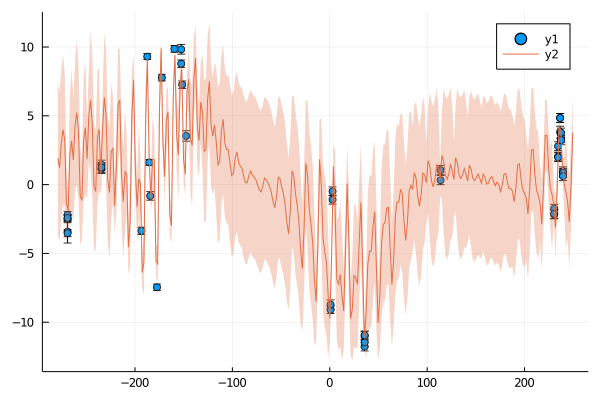

In [19]:
using Plots
plt = scatter(obs_xs, obs_rvs, yerror=obs_rvs_err)
plot!(plt, plot_xs, GLOM_rvs_at_plot_xs, ribbons=GLOM_rvs_err_at_plot_xs, fillalpha=0.3)

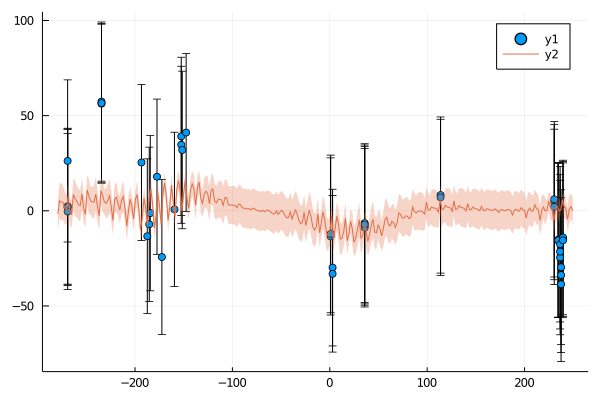

In [20]:
plt = scatter(obs_xs, obs_indicator1, yerror=obs_indicator1_err)
plot!(plt, plot_xs, GLOM_ind1_at_plot_xs, ribbons=GLOM_ind1_err_at_plot_xs, fillalpha=0.3)


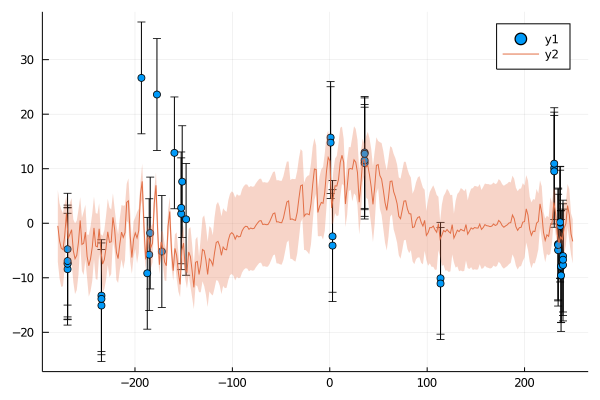

In [21]:
plt = scatter(obs_xs, obs_indicator2, yerror=obs_indicator2_err)
plot!(plt, plot_xs, GLOM_ind2_at_plot_xs, ribbons=GLOM_ind2_err_at_plot_xs, fillalpha=0.3)

In [22]:
nlogprior_hyperparameters(total_hyper::Vector, d::Int) = GLOM_RV.nlogprior_hyperparameters(kernel_hyper_priors, problem_definition.n_kern_hyper, total_hyper, d)
problem_definition_rv = GLO_RV(problem_definition, 1u"d", problem_definition.normals[1]u"m/s")


GLO_RV(GPLinearODEMaker.GLO{Float64,Int64}(GPLinearODEMaker.qp_kernel, 3, 3, 3, [-269.2213392585909, -269.2079564661908, -269.19584069718985, -269.19022286658947, -269.1841134480892, -234.42786105518826, -234.42343912379147, -234.41909104769002, -193.37810670998806, -187.37832593588973  …  234.4693607798108, 236.49587611011157, 236.50828411771, 236.5199178333096, 237.46599602491187, 237.47044131001167, 237.47468347791073, 239.4646463973113, 239.46659213601015, 239.4703088426104], [-0.438439706214198, 0.07017264493616222, -0.8215363300631974, -0.5992873961947413, 1.053953561668326, -0.4637814975278353, -0.3872871235025833, 0.09724000172072554, -0.7151996966707739, -0.4255287780362425  …  -0.9340779217760145, 0.17131411028517218, -0.5954917274915911, -0.7471532673011719, 0.14872297423445638, -0.564150916058025, -0.587135274458315, 0.1084092101315626, -0.6236031954714029, -0.6519746043930758], [0.047214930547808606, 1.651937040782559, 1.0000000000000002, 0.14472455972229797, 1.71338131232

In [23]:
println("starting hyperparameters")
println(initial_total_hyperparameters)
initial_nlogL = GLOM.nlogL_GLOM(problem_definition, initial_total_hyperparameters)
initial_uE = -initial_nlogL - nlogprior_hyperparameters(initial_total_hyperparameters, 0)
println(initial_uE, "\n")

println("ending hyperparameters")
println(fit1_total_hyperparameters)
fit_nlogL1 = GLOM.nlogL_GLOM(problem_definition, fit1_total_hyperparameters)
uE1 = -fit_nlogL1 - nlogprior_hyperparameters(fit1_total_hyperparameters, 0)
println(uE1, "\n")

starting hyperparameters
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 16.28, 32.56, 1.0]
-199.58746344538673

ending hyperparameters
[1.0015801762435164, 0.4053576562649396, -0.8239300045851049, 0.7756721757167669, -0.054677093143059914, -0.4810879136137894, 0.10207321951782455, 1.1201692784678072, -1.3915372450050174, 14.178889390494398, 30.689177223190068, 0.9752642879667336]
-135.22045044926085



In [24]:
#########################
# Keplerian periodogram #
#########################

# sample linearly in frequency space so that we get periods from the 1 / uneven Nyquist
freq_grid = GLOM_RV.autofrequency(problem_definition_rv.time; samples_per_peak=11)
period_grid = 1 ./ reverse(freq_grid)
amount_of_periods = length(period_grid)

Σ_obs = GLOM.Σ_observations(problem_definition, fit1_total_hyperparameters)

# making necessary variables local to all workers
fit1_total_hyperparameters_nz = GLOM.remove_zeros(fit1_total_hyperparameters)
nlogprior_kernel = nlogprior_hyperparameters(fit1_total_hyperparameters_nz, 0)

using Distributed

# CHANGE: can change full_fit to false to just do the epicyclic fit which is
# ~40x faster. Distributing the compute only gives me a factor of 2, so only
# try if the keplerian fitting takes a long time
use_distributed = false
full_fit = true

# concurrency is weird so you may have to run this twice
if use_distributed
    GLOM.auto_addprocs()
    @everywhere using Pkg; @everywhere Pkg.activate("examples"); @everywhere Pkg.instantiate()
    @everywhere using GLOM_RV_Example; @everywhere GLOM_RV = GLOM_RV_Example
    @everywhere import GPLinearODEMaker; @everywhere GLOM = GPLinearODEMaker
    @everywhere using UnitfulAstro, Unitful

    GLOM.sendto(workers(), kernel_name=kernel_name)
    @everywhere GLOM.include_kernel(kernel_name)

    GLOM.sendto(workers(), problem_definition_rv=problem_definition_rv, fit1_total_hyperparameters=fit1_total_hyperparameters, Σ_obs=Σ_obs, nlogprior_kernel=nlogprior_kernel, full_fit=full_fit)
end

@everywhere function fit_kep_hold_P(P::Unitful.Time; fast::Bool=false, kwargs...)
    #initialize with fast epicyclic fit
    ks = GLOM_RV.fit_kepler(problem_definition_rv, Σ_obs, GLOM_RV.kep_signal_epicyclic(P=P))
    if !fast
        ks = GLOM_RV.fit_kepler(problem_definition_rv, Σ_obs, GLOM_RV.kep_signal_wright(0u"m/s", P, ks.M0, minimum([ks.e, 0.3]), 0, 0u"m/s"); hold_P=true, avoid_saddle=false, print_stuff=false, kwargs...)
        return ks
    end
    if ks == nothing
        ks = GLOM_RV.fit_kepler(problem_definition_rv, Σ_obs, GLOM_RV.kep_signal_wright(0u"m/s", P, 2 * π * rand(), 0.1, 0, 0u"m/s"); hold_P=true, avoid_saddle=false, print_stuff=false, kwargs...)
        return ks
    end
    return ks
end
@everywhere function kep_unnormalized_posterior_distributed(P::Unitful.Time; kwargs...)
    ks = fit_kep_hold_P(P; kwargs...)
    if ks == nothing
        return [-Inf, -Inf]
    else
        val = GLOM.nlogL_GLOM(
            problem_definition_rv.GLO,
            fit1_total_hyperparameters;
            Σ_obs=Σ_obs,
            y_obs=GLOM_RV.remove_kepler(problem_definition_rv, ks))
        return [-val, GLOM_RV.logprior_kepler(ks; use_hk=false) - nlogprior_kernel - val]
    end
end
@everywhere kep_unnormalized_posterior_distributed(P::Unitful.Time) = kep_unnormalized_posterior_distributed(P; fast=!full_fit)

likelihoods = zeros(amount_of_periods)
unnorm_posteriors = zeros(amount_of_periods)

@time if use_distributed
    # takes around 8s for 101501 data with 6 workers and 1200 periods
    holder = pmap(x->kep_unnormalized_posterior_distributed(x), period_grid, batch_size=Int(floor(amount_of_periods / (nworkers() + 1)) + 1))
    likelihoods[:] = [holder[i][1] for i in 1:length(holder)]
    unnorm_posteriors[:] = [holder[i][2] for i in 1:length(holder)]
else
    # takes around 15s for 101501 data and 1200 periods
    for i in 1:amount_of_periods
        likelihoods[i], unnorm_posteriors[i] = kep_unnormalized_posterior_distributed(period_grid[i])
    end
end

best_periods = period_grid[GLOM_RV.find_modes(unnorm_posteriors; amount=10)]
best_period = best_periods[1]

println("found period:    $(ustrip(best_period)) days")

 38.210361 seconds (102.32 M allocations: 6.059 GiB, 4.38% gc time)
found period:    7.06962492623274 days


In [25]:
####################################################################################################
# Refitting GP with full planet signal at found period subtracted (K,ω,γ-linear, P,M0,e-nonlinear) #
####################################################################################################
remainder(vec, x) = [i > 0 ? i % x : (i % x) + x for i in vec]

current_ks = fit_kep_hold_P(best_period; print_stuff=true)
println("before wright fit: ", GLOM_RV.kep_parms_str(current_ks))

#=
plot_kep_xs = collect(LinRange(0, ustrip(best_period), 1000))
# scatter(remainder(problem_definition.x_obs, ustrip(best_period)), ustrip.(problem_definition_rv.rv); yerror=ustrip.(problem_definition_rv.rv_noise), label="data")
plot!(plot_kep_xs, ustrip.(current_ks.(plot_kep_xs.*u"d")); label="kep")
=#
fit2_total_hyperparameters, current_ks = GLOM_RV.fit_GLOM_and_kep!(workspace,
    problem_definition_rv, fit1_total_hyperparameters, kernel_hyper_priors,
    add_kick!, current_ks; avoid_saddle=false)

# # these should be near 0
# GLOM_RV.test_∇nlogL_kep(problem_definition_rv, workspace.Σ_obs, current_ks; include_priors=true)
###########################################################################################
# Refitting GP with full planet signal at found period subtracted (K,P,M0,e,ω,γ-nonlinear)#
###########################################################################################

current_ks = GLOM_RV.kep_signal(current_ks)
println("\nbefore full fit: ", GLOM_RV.kep_parms_str(current_ks))
fit3_total_hyperparameters, current_ks = GLOM_RV.fit_GLOM_and_kep!(workspace,
    problem_definition_rv, fit2_total_hyperparameters, kernel_hyper_priors,
    add_kick!, current_ks; avoid_saddle=true)

full_ks = GLOM_RV.kep_signal(current_ks)



Iteration:              1
Time so far:            0.0008111000061035156 s
Unnormalized posterior: 145.75737935072252
Gradient norm:          2.099167248540045


Iteration:              2
Time so far:            0.0028710365295410156 s
Unnormalized posterior: 145.74140112190065
Gradient norm:          0.15760426097240304


Iteration:              3
Time so far:            0.03655195236206055 s
Unnormalized posterior: 145.73967077589518
Gradient norm:          0.7048423047716446


Iteration:              4
Time so far:            0.03951907157897949 s
Unnormalized posterior: 145.5592726987062
Gradient norm:          4.636546508002077


Iteration:              5
Time so far:            0.04166698455810547 s
Unnormalized posterior: 145.54396628574278
Gradient norm:          4.7806316665676105


Iteration:              6
Time so far:            0.044361114501953125 s
Unnormalized posterior: 145.4355884446959
Gradient norm:          0.022147354777407154


Iteration:              7
Time so 

ending at hp   = 12.892797023429994 -> 119.9351059553781
iteration:     9
current kep:   K: 5.44m/s  P: 7.06d  M0: 5.08  e: 0.09  ω: 2.65 γ: 0.2m/s
current hyper: [0.7959915533668144, 0.25855850305492967, -0.40363126952110356, 0.06933038987510029, -1.3945252717025585, -0.5113713549097587, 0.07435710682785403, 0.17858434625666833, 1.165555336449431, 12.892797023429994, 29.631650824500813, 0.9187600082094336]
result change: 0.0002468718521129176
gridsearching over hp10
starting at hp = 12.892797023429994 -> 119.93497262714062
searching from 9.669597767572496 to 16.115996279287494
ending at hp   = 12.892797023429994 -> 119.93497262714062
gridsearching over hp10
starting at hp = 12.893035012471882 -> 119.93497184588048
searching from 9.669776259353911 to 16.11629376558985
ending at hp   = 12.893035012471882 -> 119.93497184588048
iteration:     10
current kep:   K: 5.44m/s  P: 7.06d  M0: 5.08  e: 0.09  ω: 2.65 γ: 0.2m/s
current hyper: [0.7960048994852432, 0.25848910952814674, -0.40358653695

GLOM_RV_Example.kep_signal(5.373016314424834 m s⁻¹, 7.058061058521525 d, 5.106951455267718, 0.0932234814936682, 2.6715825440816356, 0.19381009709560276 m s⁻¹, 0.042220476494393824, -0.0831146729909144)

In [26]:
###################
# Post planet fit #
###################

println("fit hyperparameters")
println(fit1_total_hyperparameters)
println(uE1, "\n")

println("kepler hyperparameters")
println(fit3_total_hyperparameters)
fit_nlogL2 = GLOM.nlogL_GLOM!(workspace, problem_definition, fit3_total_hyperparameters; y_obs=GLOM_RV.remove_kepler(problem_definition_rv, full_ks))
uE2 = -fit_nlogL2 - nlogprior_hyperparameters(fit3_total_hyperparameters, 0) + GLOM_RV.logprior_kepler(full_ks; use_hk=true)
println(uE2, "\n")

println("best fit keplerian")
println(GLOM_RV.kep_parms_str(full_ks))

fit hyperparameters
[1.0015801762435164, 0.4053576562649396, -0.8239300045851049, 0.7756721757167669, -0.054677093143059914, -0.4810879136137894, 0.10207321951782455, 1.1201692784678072, -1.3915372450050174, 14.178889390494398, 30.689177223190068, 0.9752642879667336]
-135.22045044926085

kepler hyperparameters
[0.7981113044693162, 0.2520003698826494, -0.40800227639184083, 0.06475099700355469, -1.4152826863510701, -0.4958422757790712, 0.07612011860149519, 0.17025865088076061, 1.1841811162351592, 12.916126582730003, 29.640428061366002, 0.9165390690342793]
-138.17690047374083

best fit keplerian
K: 5.37m/s  P: 7.06d  M0: 5.11  e: 0.09  ω: 2.67 γ: 0.19m/s


In [27]:
##################################################################################
# refitting noise model to see if a better model was found during planet fitting #
##################################################################################

fit1_total_hyperparameters_temp, result = GLOM_RV.fit_GLOM(
    problem_definition,
    fit3_total_hyperparameters,
    kernel_hyper_priors,
    add_kick!)

println(result)

println("first fit hyperparameters")
println(fit1_total_hyperparameters)
println(uE1, "\n")

println("fit after planet hyperparameters")
println(fit1_total_hyperparameters_temp)
fit_nlogL1_temp = GLOM.nlogL_GLOM!(workspace, problem_definition, fit1_total_hyperparameters_temp)
uE1_temp = -fit_nlogL1_temp - nlogprior_hyperparameters(fit1_total_hyperparameters_temp, 0)
println(uE1_temp, "\n")

if uE1_temp > uE1
    println("new fit is better, switching hps")
    fit1_total_hyperparameters[:] = fit1_total_hyperparameters_temp
    fit_nlogL1 = fit_nlogL1_temp
    uE1 = uE1_temp
end

gridsearching over hp10
starting at hp = 12.916126582730003 -> 174.14935736062264
searching from 9.687094937047503 to 16.145158228412505
ending at hp   = 14.207739241003004 -> 152.97820255223775
[0.7981113044693162, 0.2520003698826494, -0.40800227639184083, 0.06475099700355469, -1.4152826863510701, -0.4958422757790712, 0.07612011860149519, 0.17025865088076061, 1.1841811162351592, 14.207739241003004, 29.640428061366002, 0.9165390690342793]

[0.8831921366994282, 0.2137944628592774, -0.3110739975989465, 0.17760499551407233, -1.3823752606552695, -0.46247475703573415, -0.02096831082007483, 0.17446804591596213, 1.1236370698746447, 14.170459229455114, 29.6503900974683, 0.9698258175848737]

Iteration:              1
Time so far:            3.715097188949585 s
Unnormalized posterior: 143.32157723029093
Gradient norm:          24.95597858360005

[0.7709949399303674, 0.3324790293639556, -0.023807503000637664, 2.12715215240149, -1.4218185553537737, -0.25283567550698804, -0.03343671344613524, 0.129

-135.2204504492605

In [28]:
##########################
# Evidence approximation #
##########################

# no planet
H1 = (GLOM.∇∇nlogL_GLOM(problem_definition, fit1_total_hyperparameters)
    + nlogprior_hyperparameters(GLOM.remove_zeros(fit1_total_hyperparameters), 2))
try
    global E1 = GLOM.log_laplace_approximation(H1, -uE1, 0)
catch err
    if isa(err, DomainError)
        println("Laplace approximation failed for initial GP fit")
        println("det(H1): $(det(H1)) (should've been positive)")
        global E1 = 0
    else
        rethrow()
    end
end

# planet
H2 = Matrix(GLOM_RV.∇∇nlogL_GLOM_and_planet!(workspace, problem_definition_rv, fit3_total_hyperparameters, full_ks; include_kepler_priors=true))
n_hyper = length(GLOM.remove_zeros(fit3_total_hyperparameters))
H2[1:n_hyper, 1:n_hyper] += nlogprior_hyperparameters(GLOM.remove_zeros(fit3_total_hyperparameters), 2)
try
    global E2 = GLOM.log_laplace_approximation(Symmetric(H2), -uE2, 0)
catch err
    if isa(err, DomainError)
        println("Laplace approximation failed for planet fit")
        println("det(H2): $(det(H2)) (should've been positive)")
        global E2 = 0
    else
        rethrow()
    end
end

println("\nlog likelihood for GLOM model: " * string(-fit_nlogL1))
println("log likelihood for GLOM + planet model: " * string(-fit_nlogL2))

println("\nunnormalized posterior for GLOM model: " * string(uE1))
println("unnormalized posterior for GLOM + planet model: " * string(uE2))

println("\nevidence for GLOM model: " * string(E1))
println("evidence for GLOM + planet model: " * string(E2))


log likelihood for GLOM model: -133.00198299544675
log likelihood for GLOM + planet model: -117.04938285432655

unnormalized posterior for GLOM model: -135.2204504492605
unnormalized posterior for GLOM + planet model: -138.17690047374083

evidence for GLOM model: -133.93084850734587
evidence for GLOM + planet model: -147.93300531189212


In [30]:
post, post_err, post_obs = GLOM_RV.GLOM_posteriors(problem_definition, plot_xs, fit3_total_hyperparameters, y_obs = GLOM_RV.remove_kepler(problem_definition_rv, current_ks))

Array dimensions do not match. The matrix can't be symmetric


3-element Array{Array{Array{Float64,1},1},1}:
 [[0.6467834809984739, 0.8472307697882296, 2.032207637754741, 3.319945878810146, 2.9462010080602425, 2.8941175222524387, 2.5355723940382733, 1.0433125054083667, 1.0969572698614267, 2.5644624423367546  …  -0.6136674802725653, -0.7783761478563831, 1.9584124483009318, 5.797420220475491, 4.826192437364825, 0.4157789844645885, -1.9499312297130755, -0.7064449947080489, -0.47828555208796536, 0.7772642388582761], [3.7907029864248254, -1.7719821029401455, -4.012354447014346, 0.7573245949039282, 8.39565397719141, 1.1468260095831107, 9.511541767930508, 6.452978216696782, -1.6993637872213279, -5.29264977790676  …  -7.037389592237085, 2.1216094695768084, -20.08820302790292, -1.6245372800783389, 19.52705494548691, 22.362036333156617, -1.005771527998676, -8.977800313382902, 3.322095956153723, -14.074744739842531], [1.3745800747926253, -0.4325501230414946, -2.265956630111976, -5.641744195593551, -1.5935028508867737, -2.856157721264907, -3.433546003044818, 

In [41]:
GLOM_rvs_at_plot_xs, GLOM_ind1_at_plot_xs, GLOM_ind2_at_plot_xs = post
GLOM_rvs_err_at_plot_xs, GLOM_ind1_err_at_plot_xs, GLOM_ind2_err_at_plot_xs = post_err
GLOM_rvs_at_obs_xs, GLOM_ind1_at_obs_xs, GLOM_ind2_at_obs_xs = post_obs

3-element Array{Array{Float64,1},1}:
 [2.9087203550847, 2.9035365974884786, 2.898718511345447, 2.89644416375826, 2.8939418432538253, 5.748797475323843, 5.738854709117111, 5.729036444308441, -5.214496911971652, 4.349925311893408  …  -0.5627803949804268, 0.45727206291484873, 0.4838780782873624, 0.5090478903506559, 3.0052780756686195, 3.0176488904675103, 3.0294470605645945, 6.0271769026519735, 6.026917425933048, 6.026404411281548]
 [5.508198076390546, 5.603122107441327, 5.6892185501848935, 5.729183521483127, 5.772672978579177, 22.683425831912047, 22.763926367241517, 22.84289094591668, 9.499107229526336, -4.02654773488946  …  1.6577779688178949, -14.209646338767909, -14.388557304137338, -14.554748181946023, -20.08288442810776, -20.06452733389027, -20.046621138679605, 7.2316151458895295, 7.257005909566221, 7.305450020415936]
 [-5.071534113461348, -5.056528242208766, -5.042013533518854, -5.034984638042928, -5.027126447873991, -10.189574308540159, -10.153608762497333, -10.11805936746937, 14.1

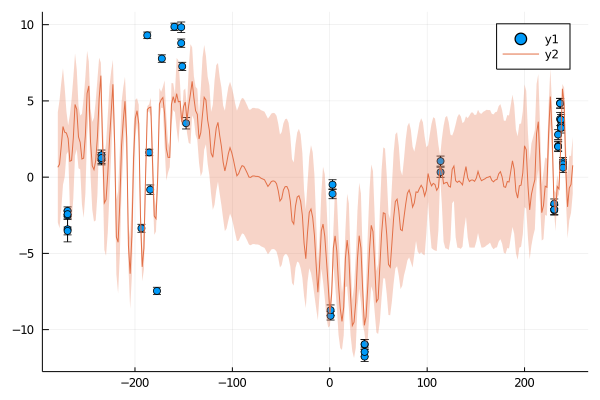

In [32]:
plt = scatter(obs_xs, obs_rvs, yerror=obs_rvs_err)
plot!(plt, plot_xs, GLOM_rvs_at_plot_xs, ribbons=GLOM_rvs_err_at_plot_xs, fillalpha=0.3)

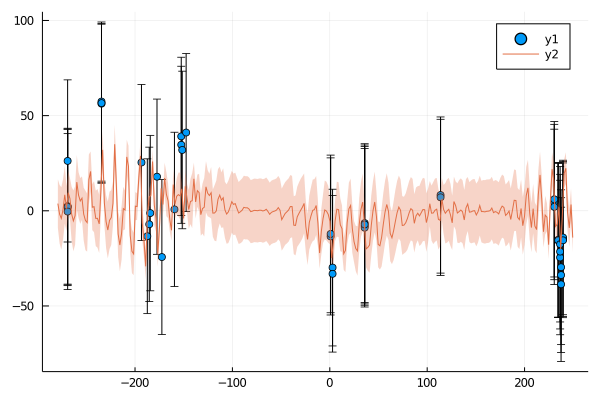

In [33]:
plt = scatter(obs_xs, obs_indicator1, yerror=obs_indicator1_err)
plot!(plt, plot_xs, GLOM_ind1_at_plot_xs, ribbons=GLOM_ind1_err_at_plot_xs, fillalpha=0.3)

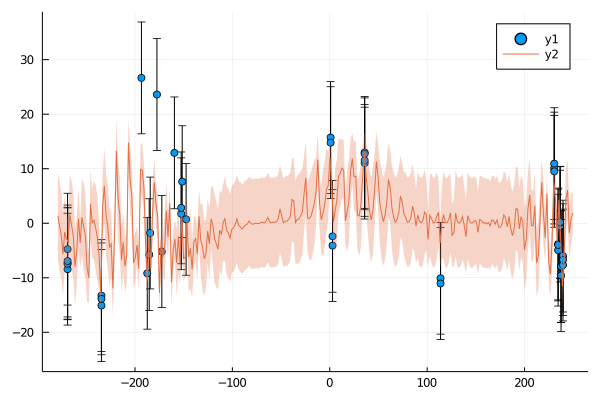

In [34]:
plt = scatter(obs_xs, obs_indicator2, yerror=obs_indicator2_err)
plot!(plt, plot_xs, GLOM_ind2_at_plot_xs, ribbons=GLOM_ind2_err_at_plot_xs, fillalpha=0.3)

In [44]:
rvs = current_ks.(obs_xs*u"d")
rvs = ustrip.(rvs)

44-element Array{Float64,1}:
 -5.572555713326815
 -5.582791791850567
 -5.591114130361066
 -5.594668514776441
 -5.598315022531855
 -4.446942700005506
 -4.462847177472828
 -4.4783958810466995
  1.888745268000721
  4.923858517443137
 -2.908025151088553
 -5.620121813863479
 -5.59152963787463
  ⋮
  2.8115886349535204
  2.8213081266069127
  2.8321015907495144
  4.230338930331261
  4.199920106946795
  4.170930040205194
  0.42795040077968927
  0.4052061427491689
  0.3834745597049132
 -5.22762754014174
 -5.223608288535346
 -5.215879877957114

In [45]:
res = obs_rvs - (GLOM_rvs_at_obs_xs + rvs)

44-element Array{Float64,1}:
  0.1625477804446307
 -0.7396644390261256
  0.48293224850461636
  0.2705932961397055
 -0.8244222540372514
 -0.15385257641103056
  0.16275001068366635
  0.001424822153593297
 -0.02823420246096564
  0.027037453969050773
 -0.03663813215709011
  0.046081832604199846
 -0.009071993794488975
  ⋮
  0.5413111866585631
 -0.2185430337273826
 -0.27502118707220546
 -0.8758857282034134
  0.1693473074146068
  0.1609741497684638
 -0.0670617150268269
  0.3494161244977061
 -0.18232426336765428
  0.17779335961323373
  0.045151717570223404
 -0.19205269608385667

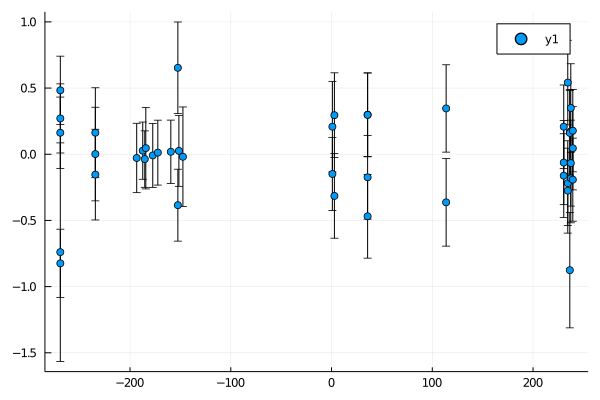

In [46]:
plt = scatter(obs_xs, res, yerror=obs_rvs_err)

In [55]:
using Plots
pyplot()

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1278


Plots.PyPlotBackend()

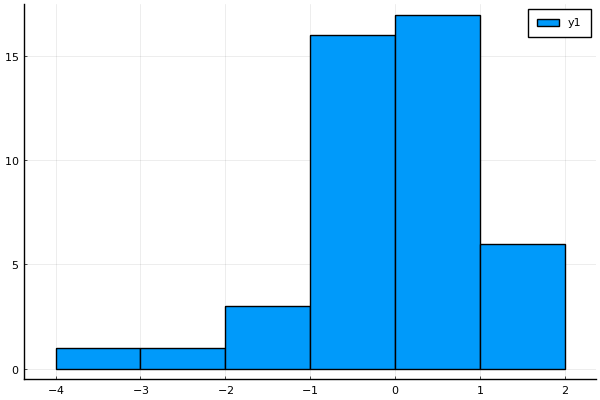

In [78]:
Plots.histogram(res./obs_rvs_err, bins=7)